# DQN example

この例では，ChainerによるDQNの実装と，OpenAI Gymへの適用を行います．

In [1]:
import copy
import random
import collections

import gym
import numpy as np
import chainer
from chainer import functions as F
from chainer import links as L
from chainer import optimizers
%matplotlib notebook
import matplotlib.pyplot as plt

まずQ関数`Q(s,a)`を近似するニューラルネット`QFunction`を定義します．この例では入出力のインタフェースを次のようにします．

- 入力：状態表現 (`ndim_obs`次元のベクトル)
- 出力：各行動毎の価値 (`n_action`次元のベクトル)

この例では全結合層とReLUからなるニューラルネットを用います．Chainerでは，全結合層は`L.Linear`，ReLUは`F.relu`に当たります．3つの全結合層からなるニューラルネットを表現するために，複数の`Link`を組み合わせた`Link`をつくることができる`chianer.Chain`を継承してニューラルネットを次のように定義します．

In [2]:
class QFunction(chainer.Chain):

    def __init__(self, ndim_obs, n_actions, n_hidden_channels=100):
        super(QFunction, self).__init__(
            l0=L.Linear(ndim_obs, n_hidden_channels),
            l1=L.Linear(n_hidden_channels, n_hidden_channels),
            l2=L.Linear(n_hidden_channels, n_actions))

    def __call__(self, x):
        h = F.relu(self.l0(x))
        h = F.relu(self.l1(h))
        return self.l2(h)

次に，アルゴリズムの実装に必要になる関数を実装していきます．

まず，先程定義した`QFunction`から，価値が最大になる行動のインデックスを計算する関数`get_greedy_action`を実装します．

- `Q.xp`は，`Q`がGPU上にあるかCPU上にあるかによって，それぞれ`cupy`，`numpy`のいずれかを表します．
- `chainer.no_backprop_mode`を使うと，Chainerはバックプロパゲーション用の計算グラフを構築せずに結果だけを計算するようになります．
- 多くのChainerの`Function`や`Link`（ここでは`Linear`）ではバッチ形式の入力が仮定されており，入力配列の1次元目がそのための次元に当たります．1つのデータ点だけについて計算を行いたい場合は，`(ndim_obs,) -> (1, ndim_obs)`のように次元を追加する必要があります．

In [3]:
def get_greedy_action(Q, obs):
    xp = Q.xp
    obs = xp.expand_dims(xp.asarray(obs, dtype=np.float32), 0)
    with chainer.no_backprop_mode():
        q = Q(obs).data[0]
    return int(xp.argmax(q))

次に，損失関数`mean_clipped_loss`を定義します．DQNでは学習の安定化のためにHuber損失を用います．Chainerの関数`F.huber_loss`は各データ点ごとにHuber損失を計算しますが，ここではさらにその平均を計算して損失とします．

In [4]:
def mean_clipped_loss(y, t):
    # Add an axis because F.huber_loss only accepts arrays with ndim >= 2
    y = F.expand_dims(y, axis=-1)
    t = F.expand_dims(t, axis=-1)
    return F.sum(F.huber_loss(y, t, 1.0)) / y.shape[0]

最後に，今実装した損失関数を使って，`QFunction`のパラメータを更新するための関数`update`を実装します．ここでは，DQNの更新式

$$Q(s,a) \leftarrow r + \gamma \max_b Q_{\text{target}}(s',b)$$

と，さらにそのバリエーションの1つであるDouble DQNの更新式

$$Q(s,a) \leftarrow r + \gamma Q_{\text{target}}(s',\text{argmax}_b Q(s',b)) $$

をバッチ形式で実装しています．`QFunction`の出力から特定のインデックスの行動の価値を取り出すには`F.select_item`を，最大価値を取り出すには`F.max`を，最大価値の行動のインデックスを計算するには`F.argmax`をそれぞれ使うことができます．

In [5]:
def update(Q, target_Q, opt, samples, gamma=0.99, target_type='double_dqn'):
    xp = Q.xp
    # Pack samples into arrays to enable batch computation
    s = xp.asarray([sample[0] for sample in samples], dtype=np.float32)
    a = xp.asarray([sample[1] for sample in samples], dtype=np.int32)
    r = xp.asarray([sample[2] for sample in samples], dtype=np.float32)
    done = xp.asarray([sample[3] for sample in samples], dtype=np.float32)
    s_next = xp.asarray([sample[4] for sample in samples], dtype=np.float32)
    # Prediction: Q(s,a)
    y = F.select_item(Q(s), a)
    # Target: r + gamma * max Q_b (s',b)
    with chainer.no_backprop_mode():
        if target_type == 'dqn':
            t = r + gamma * (1 - done) * F.max(target_Q(s_next), axis=1)
        elif target_type == 'double_dqn':
            t = r + gamma * (1 - done) * F.select_item(
                target_Q(s_next), F.argmax(Q(s_next), axis=1))
        else:
            raise ValueError('Unsupported target_type: {}'.format(target_type))
    loss = mean_clipped_loss(y, t)
    Q.cleargrads()
    loss.backward()
    opt.update()

ここまでで必要な関数の実装は終わりました．以下ではアルゴリズムの全体を記述していきます．

In [7]:
# Hyperparameters
# env_name = 'CartPole-v0'  # env to play
env_name = 'Breakout-v0'  # env to play

M = 1000  # number of episodes
replay_start_size = 500  # steps after which we start to update
steps_to_decay_epsilon = 5000  # steps to take to decay epsilon
min_epsilon = 0.01  # minimum value of epsilon
sync_interval = 100  # interval of target sync
minibatch_size = 64  # size of minibatch
reward_scale = 1e-2  # scale factor for rewards
gpu = 0  # gpu id (-1 to use cpu)
render = True  # open a rendering window (will not work without display)
target_type = 'dqn'  # 'dqn' or 'double_dqn'

# Initialize an environment
env = gym.make(env_name)
ndim_obs = env.observation_space.low.size
n_actions = env.action_space.n

# Initialize variables
D = collections.deque(maxlen=10 ** 6)  # replay memory
Rs = []  # past returns
step = 0  # total steps taken

[2016-12-29 22:22:39,665] Making new env: Breakout-v0


`QFunction`のインスタンス`Q`を作成し，GPUを使用する場合はそのための設定をします．さらに`Optimizer`（ここではAdamを使用します）のインスタンス`opt`に`Q`を渡すことで，`opt`が`Q`のパラメータを更新できるようにします．

DQNではパラメータを更新していくモデルとは別に，更新の際に目標値の計算にのみ使用するモデルを使用します．このモデルはChainerの`Optimizer`による更新は行わず，代わりに定期的にパラメータをコピーすることで同期を取ります．ここでは`copy.deepcopy`によりコピーを作ります．

In [8]:
# Initialize chainer models
Q = QFunction(ndim_obs, n_actions, n_hidden_channels=200)
if gpu >= 0:
    chainer.cuda.get_device(gpu).use()
    Q.to_gpu(gpu)
target_Q = copy.deepcopy(Q)
opt = optimizers.Adam(eps=1e-2)
opt.setup(Q)

以下がアルゴリズムの本体にあたります．環境とのインタラクションのループを回しつつ，経験をreplay memoryに蓄積していき，そこからのサンプルにより`Q`を更新していきます．環境とのインタラクションの際には，行動を$\epsilon$-greedyに従って選び，その$\epsilon$はステップが進むたびに減衰させていきます．

可視化のために各エピソードごとのスコア（報酬の和）を記録しプロットおり，学習の進行度合いを確認することができます．参考までに，CartPole-v0の最大スコアは200です．

<IPython.core.display.Javascript object>


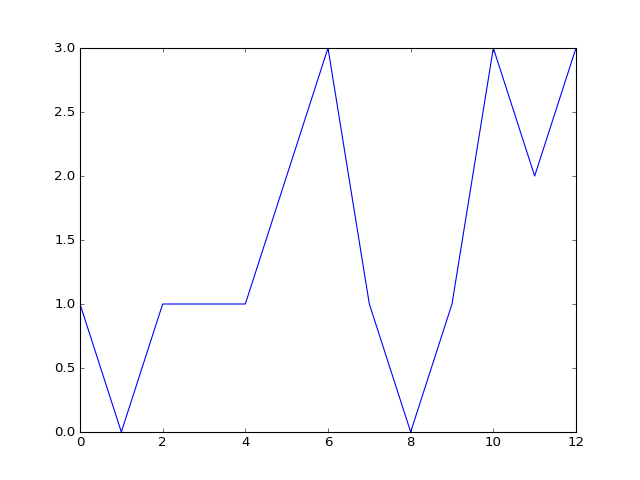

episode: 0 step: 232 R:1.0 average_R:1.0
episode: 1 step: 398 R:0.0 average_R:0.5
episode: 2 step: 625 R:1.0 average_R:0.666666666667
episode: 3 step: 854 R:1.0 average_R:0.75
episode: 4 step: 1063 R:1.0 average_R:0.8
episode: 5 step: 1306 R:2.0 average_R:1.0
episode: 6 step: 1666 R:3.0 average_R:1.28571428571
episode: 7 step: 1892 R:1.0 average_R:1.25
episode: 8 step: 2057 R:0.0 average_R:1.11111111111
episode: 9 step: 2269 R:1.0 average_R:1.1
episode: 10 step: 2624 R:3.0 average_R:1.27272727273
episode: 11 step: 2895 R:2.0 average_R:1.33333333333
episode: 12 step: 3206 R:3.0 average_R:1.46153846154


In [ ]:
# Initialize a figure
fig, ax = plt.subplots(1,1)

for episode in range(M):

    obs = env.reset()
    done = False
    R = 0.0
    t = 0

    while not done and t < env.spec.timestep_limit:

        # Select an action
        epsilon = 1.0 if len(D) < replay_start_size else \
            max(min_epsilon, np.interp(
                step, [0, steps_to_decay_epsilon], [1.0, min_epsilon]))
        if np.random.rand() < epsilon:
            a = env.action_space.sample()
        else:
            a = get_greedy_action(Q, obs)

        # Execute an action
        new_obs, r, done, _ = env.step(a)
        if render:
            env.render()
        R += r

        # Store a transition
        D.append((obs, a, r * reward_scale, done, new_obs))
        obs = new_obs

        # Sample a random minibatch of transitions
        if len(D) >= replay_start_size:
            samples = random.sample(D, minibatch_size)
            update(Q, target_Q, opt, samples, target_type=target_type)

        if step % sync_interval == 0:
            target_Q = copy.deepcopy(Q)

        step += 1
        t += 1

    Rs.append(R)
    average_R = np.mean(Rs[-100:])
    print('episode: {} step: {} R:{} average_R:{}'.format(
          episode, step, R, average_R))
    ax.clear()
    ax.plot(Rs)
    fig.canvas.draw()